In [1]:
import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import cython
%load_ext Cython

In [167]:
%%cython

import numpy as np
import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef dfdA(np.ndarray arr, double deltaL, double [::1] A, double c = 1, double bd = 0):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    #res[0] = bd
    #res[1] = (f[2] - f[1]) /( deltaL) * exp(-L[0]) * c 
    res[0] = (f[1] - f[0]) / (A[1]-A[0]) 
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = (f[i+1] - f[i-1]) / (A[i+1] - A[i-1])
    #res[0] = res[1]
    res[size - 1] = (f[-1] - f[-2]) / (A[size - 1] - A[size-2]) 
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ddfddA(np.ndarray arr, double deltaL, double [::1] A, double c = 1, double bd = 0):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    #res[0] = bd
    #res[0] = (f[1] + f[1] - 2 * f[0]) / (A[1] )**2  
    #res[1] = (f[3] + f[1] - 2 * f[2]) / ( (A[2] - A[1]) )**2  
    
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        #res[i] = (f[i+1] + f[i-1] - 2* f[i]) /( (A[i+1] - A[i-1])/2 )**2 * c**2 
        res[i] = ((f[i+1] - f[i]) / (A[i+1] - A[i]) - (f[i] - f[i-1]) / (A[i] - A[i-1])) \
            / (0.5 * (A[i+1] - A[i-1]))
    res[0] = res[1]
        
    res[size - 1] = (f[-3] + f[-1] - 2*f[-2]) / ( (A[-1] - A[-3])/2 )**2 
    return np.asarray(res)

In file included from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /root/.cache/ipython/cython/_cython_magic_37e62b6f653b400b26573d4c8d7179ff.c:637:
/usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [181]:
class MS:
    
    def __init__(self, R, m, U, w, alpha, A, rho0, deltaL, L):
        self.R = R
        self.m = m
        self.U = U
        self.w = w
        self.deltaL = deltaL
        self.L = L
        self.A = A
        self.alpha = alpha
        
        self.t0 = self.alpha * np.sqrt(3 / (8*np.pi*rho0))
        self.t = t0
        self.xi = 0

        self.RH = self.t0 / self.alpha
        self.Abar = self.A / self.RH
        self.Abar_h = self.to_h(self.A)
        
        self.q = 1
        self.deltau_i = self.cfl_deltau(R, m, U) * 0.9
        # initialize null geodesic and MS variables
        
        return
    # convert to half grid
    def to_h(self,arr):
        return np.concatenate(([arr[0]],(arr[0:-1] + arr[1:]) / 2))
    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m):
        return m + (dfdA(m, self.deltaL, self.Abar,1,0) * self.Abar * R)  \
            / (3* (self.Abar * dfdA(R, self.deltaL, self.Abar, 1, 0) 
                  + R ))
    def psi(self, rho, p, Pprime):
        return 0 + \
        integ.cumtrapz(- Pprime / (rho + p), self.Abar, initial=0)
    
    def Pprime(self, R, m):
        mprime = dfdA(m, self.deltaL, self.Abar, 1, 0)
        Rprime = dfdA(R, self.deltaL, self.Abar, 1, 0)
        mpp = ddfddA(m, self.deltaL, self.Abar, 1, 0)
        Rpp = ddfddA(R, self.deltaL, self.Abar, 1, 0)
        return self.w * (4 * self.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + self.Abar * mpp)
               + self.Abar * R * (self.Abar * Rprime * mpp + mprime * (6 * Rprime - self.Abar * Rpp))) \
                / (3 * (R + self.Abar * Rprime)**2)
    def k_coeffs(self, R, m, U) :
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        Pprime = self.Pprime(R, m)
                       
        ep = np.exp(self.psi(r, p, Pprime))
        #print(g,r,p,ep)
        kR = self.alpha * R * (U * ep - 1)
        km = 2 * m - 3 * self.alpha * U * ep * (p + m)
        
        #kU = U - self.alpha * ep * \
        #    ( g**2 * dfdA(p, self.deltaL, self.Abar, 1, 0) / 
        #     (self.Abar * R * (R + self.Abar * dfdA(R, self.deltaL, self.Abar, 1, 0)) * (r + p)) 
        #    + (2 * U**2 + m + 3 * p) / 2) 
        kU = U - self.alpha * ep * \
            (   g**2 * (Pprime[:] / 
             (self.Abar[:]))  / (R * (R + self.Abar * dfdA(R, self.deltaL, self.Abar, 1, 0)) * (r + p))  
            + (2 * U**2 + m + 3 * p) / 2) 
        #kU = U - self.alpha * ep * \
        #    (   g**2 * np.concatenate(([self.w
        #                    * ((m[1] + m[1] - 2 * m[0]) /( np.exp(2*L[0]))) *  (5/3)], dfdA(p, self.deltaL, self.Abar, 1, 0 )[1:] / 
        #     (self.Abar[1:])) ) / (R * (R + self.Abar * dfdA(R, self.deltaL, self.Abar, 1, 0)) * (r + p))  
        #    + (2 * U**2 + m + 3 * p) / 2) 
        return kR, km, kU
    
    def run_steps(self,n_steps) :
        step = 0
        
        #deltau = (self.A[1] - self.A[0]) / 1 * 0.1
        #deltau = self.cfl_deltau(R, m, U) * 0.9
        deltau = self.deltau_i
        while(step < n_steps) :
            #deltau = self.cfl_deltau(R, m, U) * 0.9
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)
            kR3, km3, kU3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, self.U + deltau/2*kU2)
            kR4, km4, kU4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, self.U + deltau*kU3)

            self.R = self.R + deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)
            self.m = self.m + deltau/6*(km1 + 2*km2 + 2*km3 + km4)
            self.U = self.U + deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4)
            
            step+=1
            self.xi += deltau
  
    def run_steps_rk2(self,n_steps) :
        step = 0
        
        #deltau = self.cfl_deltau(R, m, U) * 0.9
        deltau = self.deltau_i
        while(step < n_steps) :
            #deltau = self.cfl_deltau(R, m, U) * 0.9
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)


            self.R = self.R + deltau * kR2 
            self.m = self.m + deltau * km2 
            self.U = self.U + deltau * kU2
            
            step+=1
            self.xi += deltau
            
    def adap_run_steps(self,n_steps, adjust_steps=100, tol=1e-7) :
        step = 0
        deltau = self.deltau_i
        #q = 1
        while(step < n_steps) :
            #if (step % adjust_steps == 0): # reset_stepping size
            #    deltau = self.cfl_deltau(R, m, U) * 0.9
            #    q = 1
            
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)
            
            kR3, km3, kU3 = self.k_coeffs(self.R + 3*deltau/4*kR2, self.m + 3*deltau/4*km2, self.U + 3*deltau/4*kU2)

            

            R_new = self.R + deltau/9*(2*kR1 + 3*kR2 + 4*kR3 )
            m_new = self.m + deltau/9*(2*km1 + 3*km2 + 4*km3 )
            U_new = self.U + deltau/9*(2*kU1 + 3*kU2 + 4*kU3 )
            
            kR4, km4, kU4 = self.k_coeffs(R_new , m_new , U_new )
            
            E_R = np.max( np.abs((deltau * (-5*kR1/72 + kR2/12 + kR3/9 - kR4/8))))
            E_m = np.max( np.abs(deltau * (-5*km1/72 + km2/12 + km3/9 - km4/8)))
            E_U = np.max( np.abs(deltau * (-5*kU1/72 + kU2/12 + kU3/9 - kU4/8)))
    
            max_err_R = np.max(np.abs(self.R)) * tol
            max_err_m = np.max(np.abs(self.m)) * tol
            max_err_U = np.max(np.abs(self.U)) * tol
            
            if(E_R < max_err_R and E_m < max_err_m and E_U < max_err_U):
                self.R = R_new
                self.m = m_new
                self.U = U_new
                
                kR1 = kR4
                km1 = km4
                kU1 = kU4
                
                step+=1
                self.xi += deltau
                         
            # Adjust step size.
            self.q = 0.8*np.min((max_err_R/E_R, max_err_m/E_m, max_err_U/E_U) )**(1/3)   # conservative optimal step factor
            self.q = min(self.q,10)               # limit stepsize growth
            deltau *= self.q
            #print(q, E_R, max_err_R)
            
    def cfl_deltau(self,R, m, U):
        a = np.exp(self.alpha * self.xi)
        H = np.exp(-self.xi) / self.RH
        
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        Pprime = self.Pprime(R, m)
                           
        ep = np.exp(self.psi(r, p, Pprime))
        el = (a * H * self.RH * g) / (dfdA(a * self.A * self.R, self.deltaL, self.Abar, 1, 1) / self.RH) 
        #print(el, ep.min())
        #return (np.log(1 + el / ep / np.exp(self.xi)  
        #               * self.alpha * np.concatenate( ([1e10],(Abar[1:] - Abar[0:-1])) ) / np.sqrt(self.w))).min()
        return (np.log(1 + el / ep / np.exp(self.xi)  
                       * self.alpha * (Abar[1] - Abar[0]) / np.sqrt(self.w))).min()

In [174]:
n=300

L = np.linspace(-6, 1.5, n)
A = np.exp(L)

#A = np.concatenate( ([0], A))


w = 1 / 3
alpha = 1/2 # alpha = 1/2 for w = 1/3


rho0 = 1
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0))
RH = t0 / alpha
Abar = A / RH

deltaL = L[2] - L[1]

deltaA = Abar[1] - Abar[0]

amp = 0.3
delta0 = amp * np.exp(-2 * Abar**2 / RH / 30)
delta0P = amp * delta0 * 2 * (-2 / RH / 30 ) * Abar

m = 1 + delta0 
U = 1 - alpha * delta0 / 2
R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )


ms = MS(R,m,U,w,alpha,A,rho0, deltaL,L)

In [175]:
ms.cfl_deltau(R, m, U)

6.23708701000024e-05

In [176]:
ms.adap_run_steps(20000)

In [170]:
ms.run_steps(53600)

In [177]:
ms.xi

2.9921755513864046

(0.0, 30.0)

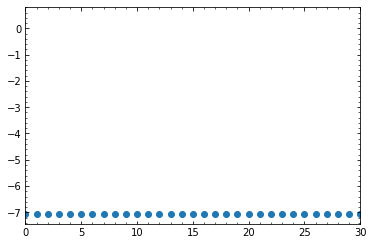

In [178]:
plt.scatter(np.arange(n), ms.U[:])
plt.xlim(0,30)
#plt.ylim(0.915,0.93)

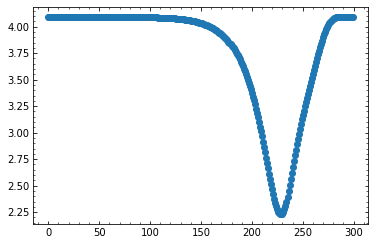

In [763]:
plt.scatter(np.arange(n), ms.gamma(ms.R, ms.m, ms.U))
#plt.xlim(0,30)
#plt.ylim(0.915,0.93)

(0.0, 30.0)

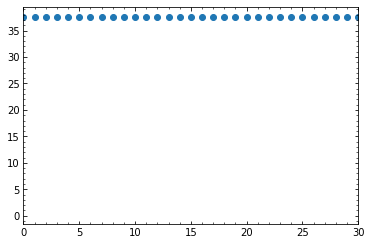

In [40]:
plt.scatter(np.arange(n), ms.rho(ms.R, ms.m))
plt.xlim(0,30)
#plt.ylim(0.915,0.93)

(0.0, 10.0)

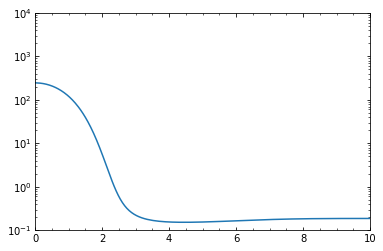

In [165]:
plt.plot(Abar, ms.rho(ms.R, ms.m) )
plt.yscale('log')
plt.ylim(10**-1,10**4)
plt.xlim(0,10)

(0.0, 10.0)

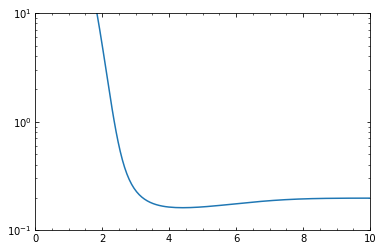

In [182]:
plt.plot(Abar, ms.rho(ms.R, ms.m) )
plt.yscale('log')
plt.ylim(10**-1,10**1)
plt.xlim(0,10)

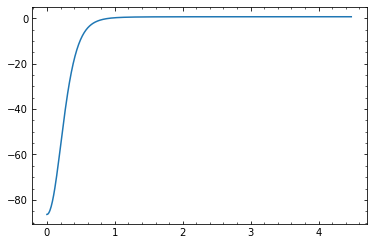

In [1587]:
plt.plot(A[:], ms.U[:] )


(0.0, 4.0)

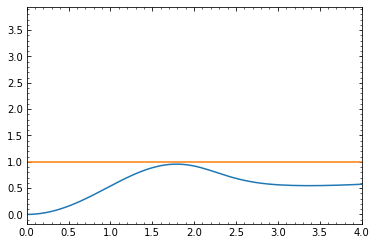

In [180]:
plt.plot(Abar, ms.R**2 * ms.m * ms.Abar**2 * np.exp(2 * (ms.alpha-1) * ms.xi))
plt.plot(Abar, np.array([1]*n))
plt.xlim(0,4)

(0.0, 4.0)

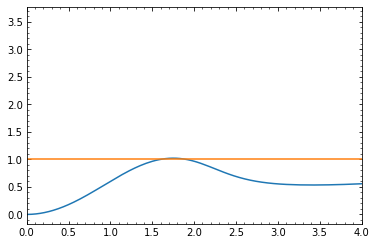

In [163]:
plt.plot(Abar, ms.R**2 * ms.m * ms.Abar**2 * np.exp(2 * (ms.alpha-1) * ms.xi))
plt.plot(Abar, np.array([1]*n))
plt.xlim(0,4)

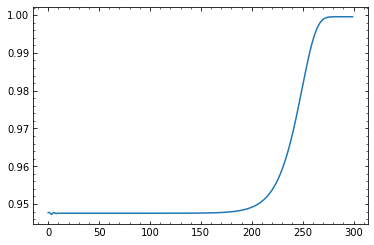

In [632]:
plt.plot( ms.U[:])
#plt.xlim(0,50)
#plt.ylim(0.87,0.92)

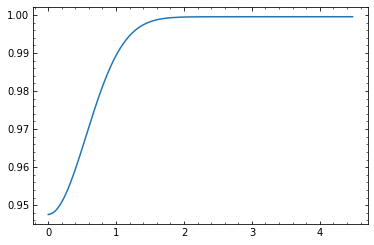

In [631]:
plt.plot(A[20:], ms.U[20:])


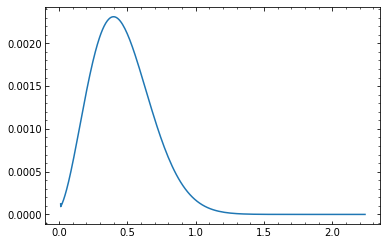

In [319]:
plt.plot(A[5:], (dfdA(ms.U[5:], ms.deltaL, ms.L, ms.RH) ))

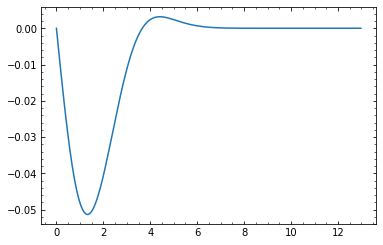

In [747]:
plt.plot(ms.Abar, (ms.w * (4 * ms.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + ms.Abar * mpp)
               + ms.Abar * R * (ms.Abar * Rprime * mpp + mprime * (6 * Rprime - ms.Abar * Rpp))) \
                / (3 * (R + ms.Abar * Rprime)**2) ))

In [699]:
 (ms.w * (4 * ms.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + ms.Abar * mpp)
               + ms.Abar * R * (ms.Abar * Rprime * mpp + mprime * (6 * Rprime - ms.Abar * Rpp))) \
                / (3 * (R + ms.Abar * Rprime)**2) )[0:10]

array([ 0.        , -0.00056319, -0.00047334, -0.0004854 , -0.00049777,
       -0.00051046, -0.00052347, -0.00053681, -0.00055049, -0.00056452])

(-1.0, 30.0)

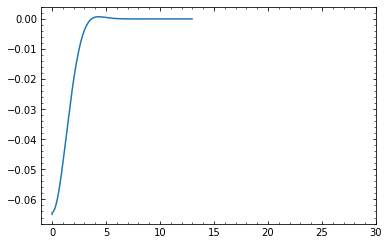

In [746]:
        mprime = dfdA(m, ms.deltaL, ms.Abar, 1, 0)
        Rprime = dfdA(R, ms.deltaL, ms.Abar, 1, 0)
        mpp = ddfddA(m, ms.deltaL, ms.Abar, 1, 0)
        Rpp = ddfddA(R, ms.deltaL, ms.Abar, 1, 0)
        plt.plot(ms.Abar[1:], (ms.w * (4 * ms.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + ms.Abar * mpp)
               + ms.Abar * R * (ms.Abar * Rprime * mpp + mprime * (6 * Rprime - ms.Abar * Rpp))) \
                / (3 * (R + ms.Abar * Rprime)**2) )[1:] / ms.Abar[1:])
        plt.xlim(-1,30)

In [ ]:
(R[3] + R[1] - 2 * R[2]) / ( (Abar[2] - Abar[1]) )**2

0.06530870477810906

In [724]:
i = 3
(R[i+1] + R[i-1] - 2 * R[i]) / ( (Abar[i+1] - Abar[i-1]) / 2 )**2

0.06367538184774105

In [723]:
i = 3
((R[i+1] - R[i]) / (Abar[i+1] - Abar[i]) - (R[i] - R[i-1]) / (Abar[i] - Abar[i-1])) \
            / (0.5 * (Abar[i+1] - Abar[i-1]))

0.03183730852799588

In [742]:
i = 3
((R[i+1] - R[i]) / (Abar[i+1] - Abar[i]) - (R[i] - R[i-1]) / (Abar[i] - Abar[i-1])) \
            / (0.00018)

0.033589810921563754

In [733]:
Abar[i+1] - Abar[i]

0.00019229785859318452

In [726]:
(0.5 * (Abar[i+1] - Abar[i-1]))

0.00018990820032933464

In [728]:
 (Abar[i+1] - Abar[i-1]) / 2

0.00018990820032933464

In [704]:
ddfddA(R, ms.deltaL, ms.Abar, 1, 0)[0:10]

array([0.03183828, 0.0653087 , 0.03183737, 0.03183731, 0.03183725,
       0.03183719, 0.03183712, 0.03183705, 0.03183698, 0.03183691])

In [682]:
dfdA(R, ms.deltaL, ms.Abar, 1, 0)[0:10]

array([0.        , 0.00023133, 0.00023432, 0.00024029, 0.00024641,
       0.0002527 , 0.00025914, 0.00026574, 0.00027251, 0.00027946])

(-1.0, 30.0)

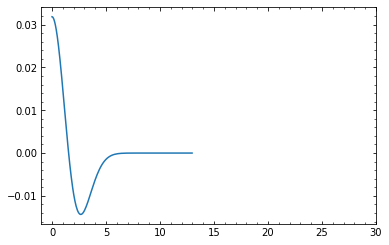

In [745]:
plt.plot(ms.Abar,ddfddA(R, ms.deltaL, ms.Abar, 1, 0))
plt.xlim(-1,30)